In [98]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.svm import SVC

import matplotlib.pyplot as plt

In [99]:
# читаем датасет
df = pd.read_csv( 'adult.csv' )
# все признаки
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [108]:
# анализируемые признаки
used_cols = [
        'age', # гаусс, но обрезанный, только больше 12 лет где-то - https://prnt.sc/w82zxx  - можно попробовать нормировать
    'workclass', 
    # 'fnlwgt', # пока не трогаю, оценку ухудшает
    #  'education', # есть цифровой признак - этот не нужен - попробовал, ухудшает score
        'educational-num', # можно попробовать нормировать - есть центральные максимумы, хвост слева, но посередине дырка
       'marital-status', 
       'occupation', 
       'relationship', 
       'race', 
       'gender', # 
       'capital-gain', # распределение скорее пуассоновское 
      #  'capital-loss', # очень мало не 0 -  сильно (на 3%) ухудшает score. странно, может нужно с обратным знаком брать?
       'hours-per-week',
    #    'native-country', # интересно - ухудшает оценку
    #    'income' - целевой признак
       ]
# нечисловые признаки
cat_cols = ['gender', 'race', 'marital-status','occupation','relationship','education','workclass', 'native-country',
#  'capital-loss'
 ]


,age,workclass,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,hours-per-week
0,-0.995129,Private,-1.197259,Never-married,Machine-op-inspct,Own-child,Black,Male,-0.144804,-0.034087
1,-0.046942,Private,-0.419335,Married-civ-spouse,Farming-fishing,Husband,White,Male,-0.144804,0.772930
2,-0.776316,Local-gov,0.747550,Married-civ-spouse,Protective-serv,Husband,White,Male,-0.144804,-0.034087
3,0.390683,Private,-0.030373,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,0.886874,-0.034087
4,-1.505691,?,-0.030373,Never-married,?,Own-child,White,Female,-0.144804,-0.841104
...,...,...,...,...,...,...,...,...,...,...
48837,-0.849254,Private,0.747550,Married-civ-spouse,Tech-support,Wife,White,Female,-0.144804,-0.195490
48838,0.098933,Private,-0.419335,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,-0.144804,-0.034087
48839,1.411808,Private,-0.419335,Widowed,Adm-clerical,Unmarried,White,Female,-0.144804,-0.034087
48840,-1.213941,Private,-0.419335,Never-married,Adm-clerical,Own-child,White,Male,-0.144804,-1.648120


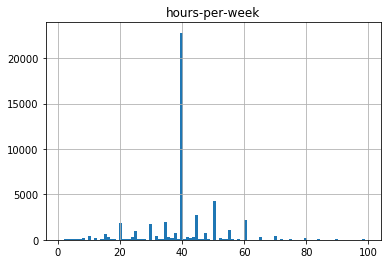

In [111]:

scaler = StandardScaler()
# cols_w_zeros = ['capital-gain',] 
# df[cols_w_zeros] = df[cols_w_zeros].replace({0:np.nan}) # None не переваривается скейлером - только дропать
df = pd.read_csv( 'adult.csv' )
df['index1'] = df.index
# scaler.fit(df[['index1','age']])
cols_to_norm = ['index1','age',
'educational-num',
 'hours-per-week',
 'capital-gain'
 ]
dff = df.copy()

df.hist(column='hours-per-week',bins=100) # before scaling

dff[cols_to_norm] = pd.DataFrame(scaler.fit_transform(df[cols_to_norm]),columns=cols_to_norm)
# dff.hist(column='hours-per-week',bins=100) # after scaling

# X = dff[used_cols]
dff[used_cols]

In [112]:

X = pd.get_dummies(dff[used_cols], columns=[c for c in cat_cols if c in used_cols])

le = LabelEncoder()
le.fit( df['income'] )
# le.classes_
y = pd.Series( data = le.transform( df['income'] ) )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = LogisticRegression()
model.fit( X_train, y_train )
# predictions = model.predict_proba( X_train )
# model.predict(X)
model.score(X_test, y_test)

0.8539521032386153

0.8539521032386153 - максимальный score на 2020-12-23--11-35 - со стандартизацией величин, которые как-то похожи на стандартные  
0.8435910162551185 - максимальный score на 2020-12-21--21-10 - просто за счет выбора колонок, без преобработки скейлерами



In [4]:
model2 = SVC(kernel='poly', degree=2) # TODO зависает на большой выборке - посмотреть на нормальный размер выборки
# TODO нормировать нормальные величины 
model2.fit( X[:100], y[:100] )
# model2.predict_proba(X)[:5]
model2.score(X[500:1000],y[500:1000])

0.792

In [5]:
# TODO - переписать на pipeline вроде этого отсюда https://medium.com/bigdatarepublic/integrating-pandas-and-scikit-learn-with-pipelines-f70eb6183696

transformer = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[
        # Part 1
        ('boolean', Pipeline([
            ('selector', TypeSelector('bool')),
        ])),  # booleans close
        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('scaler', StandardScaler()),
        ])),  # numericals close
        
        # Part 2
        ('categoricals', Pipeline([
            ('selector', TypeSelector('category')),
            ('labeler', StringIndexer()),
            ('encoder', OneHotEncoder(handle_unknown='ignore')),
        ]))  # categoricals close
    ])),  # features close
])  # pipeline close

NameError: name 'Pipeline' is not defined